# <center>Finding Donors for *CharityML*</center>

## Table of Contents

- [Introduction](#introduction)
- [Exploration and Preprocessing](#exploration_and_preprocessing)
    - [Logarithmic Transformation](#logarithmic_transformation)
    - [Normalization](#normalization)
    - [One-Hot Encoding](#one-hot_encoding)
    - [Splitting](#splitting)
- [Choosing a Model](#choosing_a_model)
    - [Implementation](#implementation1)
    - [Improving Results](#improving_results)

----

<a id='introduction'></a>

## Introduction

In [1]:
# Importing packages
from time import time
import pandas as pd
import numpy as np
import visuals as vs
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
# Plotting graphs inside the notebook
%matplotlib inline

# 0: black, 1: white
vs.set_color(0)

----

<a id='exploration_and_preprocessing'></a>

## Exploration and Preprocessing

In [3]:
# Loading the dataset and displaying the first row
df = pd.read_csv('census.csv')
df.head(1)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


**Continous Features**
> '`age`', '`education-num`', '`capital-gain`', '`capital-loss`', '`hours-per-week`'

**Categorical Features**
> '`workclass`', '`education`', '`marital-status`', '`occupation`', '`relationship`', '`race`', '`sex`', '`native-country`', 
'`income`'

In [4]:
n_records = df.shape[0]
print(f'Total number of records: {n_records}')

n_at_most_50k = df[df['income'] == '<=50K'].shape[0]
print('Individuals making at most $50,000: {}'.format(n_at_most_50k))

n_greater_50k = df[df['income'] == '>50K'].shape[0]
print(f'Individuals making more than $50,000: {n_greater_50k} ({round((n_greater_50k / n_records) * 100, 4)}%)')

Total number of records: 45222
Individuals making at most $50,000: 34014
Individuals making more than $50,000: 11208 (24.7844%)


In [5]:
# Generating descriptive statistics of continous features
df.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


<a id='logarithmic_transformation'></a>

### Logarithmic Transformation

> '`capital-gain`' and '`capital-loss`' appear to be heavily skewed (their values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number). Algorithms can be sensitive to such distributions, and can underperform if the range is not properly normalized.

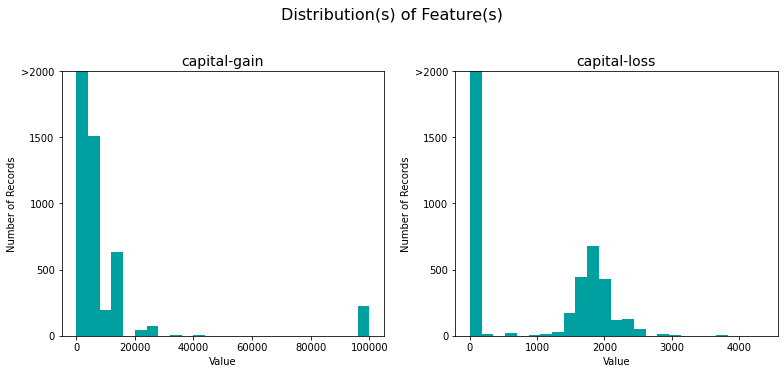

In [6]:
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
skewed = [numerical[2], numerical[3]]

# Visualizing distributions of skewed continuous features
vs.distribution(df, skewed)

> [Logarithmic transformation](https://en.wikipedia.org/wiki/Data_transformation_(statistics)) should be applied to '`capital-gain`' and '`capital-loss`' so that the very large and very small values do not negatively affect the performance of a learning algorithm. The logarithm of `0` is undefined, so we must shift the values by a small amount above `0` in order for the transformation to be successful.

In [7]:
# Splitting data into features and income
features_df = df.drop('income', axis=1)
income_df = df['income']

In [8]:
# Creating a duplciate dataframe and log-transforming the skewed features
features_log_transformed = features_df.copy()
features_log_transformed[skewed] = features_df[skewed].apply(lambda x: np.log(x + 1))

<a id='normalization'></a>

### Normalization

> Using sklearn's [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) on continuous features to ensure that each feature is treated equally when applying a learning algorithm.

In [9]:
# Initializing a scaler
scaler = MinMaxScaler()

# Creating a duplicate dataframe and normalizing the features
features_log_minmax_transform = features_log_transformed.copy()
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

features_log_minmax_transform.head(1)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States


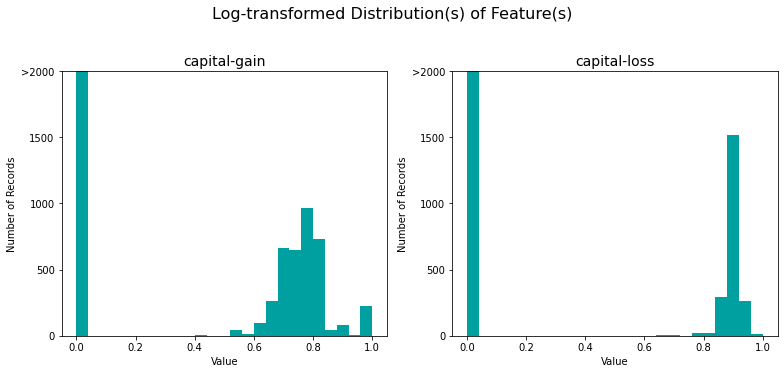

In [10]:
# Visualizing distributions of log-transformed continuous features
vs.distribution(features_log_minmax_transform, skewed, True)

<a id='one-hot_encoding'></a>

### One-Hot Encoding

> Learning algorithms expect input to be numeric, which requires categorical features to be converted. One popular method is using the `one-hot encoding` scheme. It creates a dummy variable for each possible category of each categorical feature.

In [11]:
# One-hot encoding
features_final = pd.get_dummies(features_log_minmax_transform)
features_final.head(1)

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.30137,0.8,0.667492,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
# Mapping the 'income_raw' data to numerical values
income = income_df.map({'<=50K':0, '>50K':1})

<a id='splitting'></a>

### Splitting

> Now all categorical features have been converted into numerical features, and all numerical features have been normalized. Data should be split into training (`80%`) and testing (`20%`) sets.

In [13]:
# Splitting data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features_final, income, test_size=.2, random_state=0)
n_train, n_test = x_train.shape[0], x_test.shape[0]

print(f'Training set has {n_train} samples.')
print(f'Testing set has {n_test} samples.')

Training set has 36177 samples.
Testing set has 9045 samples.


----

<a id='choosing_a_model'></a>

## Choosing a Model

> In this section, four different models will have their performance metrics evaluated using a custom-tailored '`pipeline`'.

In [14]:
def train_and_predict(learner, x_train, y_train, x_test, y_test) -> dict: 
   '''
      Train and predict pipeline
   '''
   results = {}   
   start = time()
   # Fitting the model to the training data
   _learner = learner.fit(x_train, y_train)
   results['t_time'] = f'{round(time() - start, 4)}s'

   start = time()
   # Making predictions using the testing data
   preds = _learner.predict(x_test)
   results['p_time'] = f'{round(time() - start, 4)}s'

   # Computing accuracy
   results['accuracy'] = f'{(accuracy_score(y_test, preds) * 100):.2f}%'
   
   # Computing F-score
   results['f_score'] = f'{(fbeta_score(y_test, preds, beta=.5) * 100):.2f}%'

   print(f'{_learner.__class__.__name__} ✓')
   return results

<a id='implementation'></a>

### Implementation

In [15]:
# Initializing the three models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(random_state=42)
clf_C = RandomForestClassifier(random_state=42)
clf_D = SVC(random_state=42)

results = {}
# Iteratively running the pipeline using different sample sizes
for ss in [.25, .5, .75, 1]:
    results[ss] = {}
    ss1, ss2 = round(n_train * ss), round(n_test * ss)
    print(f'Training {ss1} Samples & Predciting {ss2} Samples')
    for clf in [clf_A, clf_B, clf_C, clf_D]:
        results[ss][clf.__class__.__name__] = train_and_predict(clf, x_train[:ss1], y_train[:ss1], x_test[:ss2], y_test[:ss2])

Training 9044 Samples & Predciting 2261 Samples
GaussianNB ✓
DecisionTreeClassifier ✓
RandomForestClassifier ✓
SVC ✓
Training 18088 Samples & Predciting 4522 Samples
GaussianNB ✓
DecisionTreeClassifier ✓
RandomForestClassifier ✓
SVC ✓
Training 27133 Samples & Predciting 6784 Samples
GaussianNB ✓
DecisionTreeClassifier ✓
RandomForestClassifier ✓
SVC ✓
Training 36177 Samples & Predciting 9045 Samples
GaussianNB ✓
DecisionTreeClassifier ✓
RandomForestClassifier ✓
SVC ✓


In [16]:
dfs = []
# Looping through sample sizes
for a in results:
    d = {}
    # Looping through models
    for b in results[a]:
        r = []
        for c in results[a][b]:
            r.append(results[a][b][c])
        d[b] = r
    dfs.append(pd.DataFrame(data=d, index=['Training Time', 'Prediction Time', 'Accuracy', 'F-score']).\
        style.set_caption(f'{(a * 100):.0f}%'))

In [17]:
vs.displayx(dfs)

,GaussianNB,DecisionTreeClassifier,RandomForestClassifier,SVC
Training Time,0.048s,0.113s,1.577s,5.759s
Prediction Time,0.016s,0.007s,0.07s,1.308s
Accuracy,37.59%,79.57%,82.97%,83.59%
F-score,31.45%,56.56%,63.64%,65.44%
,GaussianNB,DecisionTreeClassifier,RandomForestClassifier,SVC
Training Time,0.061s,0.232s,2.712s,25.495s
Prediction Time,0.02s,0.009s,0.141s,5.603s
Accuracy,47.46%,81.71%,83.97%,84.25%
F-score,35.21%,61.03%,65.94%,67.14%
,GaussianNB,DecisionTreeClassifier,RandomForestClassifier,SVC


> It's clear that the '`RandomForestClassifier`' have outperformed the other three candidates in terms of accuracy and F-score (against time).

<a id='improving_results'></a>

### Improving Results

> In this section, three different parameters will be fine-tuned as a mean to improve the model's performance.

In [18]:
params = clf_C.get_params()
pd.DataFrame(data=params.values(), index=params.keys(), columns=['RandomForestClassifier'])

,RandomForestClassifier
bootstrap,True
ccp_alpha,0.0
class_weight,None
criterion,gini
max_depth,None
max_features,auto
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,0.0
min_samples_leaf,1


In [19]:
# Initializing the model
clf = RandomForestClassifier(random_state=42)

parameters = {'max_depth': [2, 4, 6, 8, 10], 'min_samples_leaf': [2, 4, 6, 8, 10],'min_samples_split': [2, 4, 6, 8, 10]}

# Making a scorer and preforming a grid search
scorer = make_scorer(fbeta_score, beta=.5)
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters, scoring=scorer)

# Fitting the grid search object with the training data
grid_fit = grid_obj.fit(x_train, y_train)

# Make predictions using the optimized model
best_clf = grid_fit.best_estimator_
best_predictions = best_clf.predict(x_test)

In [20]:
params = best_clf.get_params()
print(f"max_depth: {params['max_depth']}")
print(f"min_samples_leaf: {params['min_samples_leaf']}")
print(f"min_samples_split: {params['min_samples_split']}")

max_depth: 10
min_samples_leaf: 2
min_samples_split: 8


In [21]:
old_acc = float(results[1]['RandomForestClassifier']['accuracy'][:-1])
new_acc = round(accuracy_score(y_test, best_predictions) * 100, 2)

print(f'Δ Accuracy: {(new_acc - old_acc):.2f}%')

Δ Accuracy: 1.38%


In [22]:
old_fscore = float(results[1]['RandomForestClassifier']['f_score'][:-1])
new_fscore = round(fbeta_score(y_test, best_predictions, beta=.5) * 100, 2)

print(f'Δ F-score: {(new_fscore - old_fscore):.2f}%')

Δ F-score: 4.78%


> After fine-tuning three parameters ('`max_depth`', '`min_samples_leaf`', and '`min_samples_split`'), both accuracy and F-score increased.

In [23]:
# Saving the model
pickle.dump(best_clf, open('best_clf', 'wb'))

<center>-</center>